## **Import Libraries and Packages**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout, Concatenate, BatchNormalization, Conv2D

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


from glob import glob


In [ ]:
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.vgg19 import VGG19 ,preprocess_input

In [ ]:
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam, SGD
from keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)

## **Downloading Data**

In [ ]:
!gdown --id 1FxvmwTrYZsMyCMfH_mcrLJ2oStXABQG_

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1FxvmwTrYZsMyCMfH_mcrLJ2oStXABQG_
To: /content/dataset.zip
100% 1.26G/1.26G [00:38<00:00, 32.3MB/s]


## **Creating Dataset**

In [ ]:
!mkdir datasets

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('dataset.zip','r')
zip_ref.extractall('/content/datasets')
zip_ref.close()

In [ ]:
import os

In [ ]:
x = os.listdir("/content/datasets/chest_xray/test/PNEUMONIA")
y = os.listdir("/content/datasets/chest_xray/test/NORMAL")

In [ ]:
Train_path = "/content/datasets/chest_xray/train"
Test_path = "/content/datasets/chest_xray/test"

img_size = [224,224]
batch_sze = 32
epochs = 15


### **Creating ImageDataGenerator instance**

In [ ]:
img_gen = ImageDataGenerator(rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    shear_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,

)

train_gen = img_gen.flow_from_directory(
    "/content/datasets/chest_xray/train",
    target_size=img_size,
    batch_size= batch_sze,
    class_mode="categorical",
)




valid_gen = img_gen.flow_from_directory(
    "/content/datasets/chest_xray/test",
    target_size=img_size,
    batch_size= batch_sze,
    class_mode="categorical",
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
len(train_gen)

164

## **Using HuggingFace Transformers**

In [ ]:
! pip install datasets transformers

## **Data-efficient Image Transsformer With Teacher**

In [ ]:
from transformers import TFDeiTForImageClassificationWithTeacher

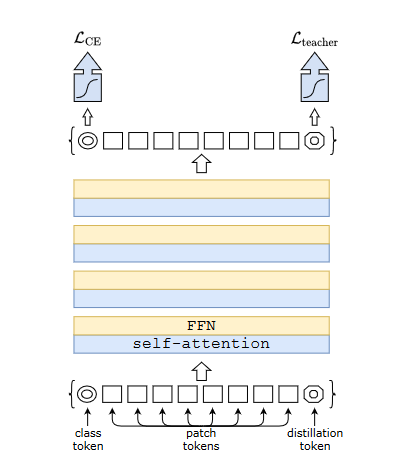

## **Creating Complete Model**

In [ ]:
base_model = TFDeiTForImageClassificationWithTeacher.from_pretrained(model_name_or_path, ignore_mismatched_sizes =True)
base_model.trainable=False

All model checkpoint layers were used when initializing TFDeiTForImageClassificationWithTeacher.

All the layers of TFDeiTForImageClassificationWithTeacher were initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDeiTForImageClassificationWithTeacher for predictions without further training.


In [ ]:
inputs = Input(shape = (3,224,224))
x = base_model(inputs)['cls_logits']

#x = base_model.get_layer('deit')(inputs)[0][:,0,:]
x = Dense(2,activation='softmax')(x)

In [ ]:
model = Model(inputs = inputs,outputs = x)

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = ["accuracy"]

In [ ]:
model.compile(optimizer = Adam(learning_rate = .001),
  loss = loss_function,
  metrics = metrics)

### **Preparing Data to the DeiTFeatureExtractor**

In [ ]:
X_train = []
y_train = []

for _ in range(50):
    images, labels = next(train_gen)
    X_train.append(images)
    y_train.append(labels)

X_train[0].shape

(32, 224, 224, 3)

In [ ]:
X_train = tf.concat(X_train, axis=0)
y_train = tf.concat(y_train,axis=0).numpy()

In [ ]:
y_train.shape

(1600, 2)

In [ ]:
X_val = []
y_val = []

for _ in range(10):
    images, labels = next(valid_gen)
    X_val.append(images)
    y_val.append(labels)

X_val = tf.concat(X_val, axis=0)
y_val = tf.concat(y_val,axis=0).numpy()

## **Doing the required preprocessing to the input tensor of images**

In [ ]:
from transformers import DeiTFeatureExtractor

model_name_or_path = 'facebook/deit-base-distilled-patch16-224'
feature_extractor = DeiTFeatureExtractor.from_pretrained(model_name_or_path)
#feature_extractor.do_normalize=False

/usr/local/lib/python3.10/dist-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


In [ ]:
feature_extractor

In [ ]:
X_features = feature_extractor(X_train, return_tensors='tf')['pixel_values']
X_features_val = feature_extractor(X_val, return_tensors='tf')['pixel_values']

## **Training**

In [ ]:
model.fit(x=X_features,y= y_train, validation_data=(X_features_val, y_val),epochs = 20 )

Epoch 1/20
50/50 [==============================] - 37s 608ms/step - loss: 0.5235 - accuracy: 0.7381 - val_loss: 0.6342 - val_accuracy: 0.6094
Epoch 2/20
50/50 [==============================] - 30s 597ms/step - loss: 0.4484 - accuracy: 0.7625 - val_loss: 0.5767 - val_accuracy: 0.6781
Epoch 3/20
50/50 [==============================] - 28s 561ms/step - loss: 0.4285 - accuracy: 0.7700 - val_loss: 0.5561 - val_accuracy: 0.7063
Epoch 4/20
50/50 [==============================] - 29s 581ms/step - loss: 0.4074 - accuracy: 0.7981 - val_loss: 0.6477 - val_accuracy: 0.6531
Epoch 5/20
50/50 [==============================] - 29s 576ms/step - loss: 0.3979 - accuracy: 0.8025 - val_loss: 0.5430 - val_accuracy: 0.7094
Epoch 6/20
50/50 [==============================] - 28s 569ms/step - loss: 0.3887 - accuracy: 0.8225 - val_loss: 0.5873 - val_accuracy: 0.7000
Epoch 7/20
50/50 [==============================] - 29s 575ms/step - loss: 0.3796 - accuracy: 0.8188 - val_loss: 0.5465 - val_accuracy: 0.7094

## **Evaluation**

In [ ]:
model.evaluate(X_features_val, y_val)

10/10 [==============================] - 5s 468ms/step - loss: 0.5433 - accuracy: 0.7344


[0.5433226823806763, 0.734375]

In [ ]:
predictions = model.predict(X_features_val)

10/10 [==============================] - 6s 477ms/step


In [ ]:
predictions = np.argmax(predictions, axis = 1 )
y_true = np.argmax(y_val, axis = 1 )

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_true,predictions)

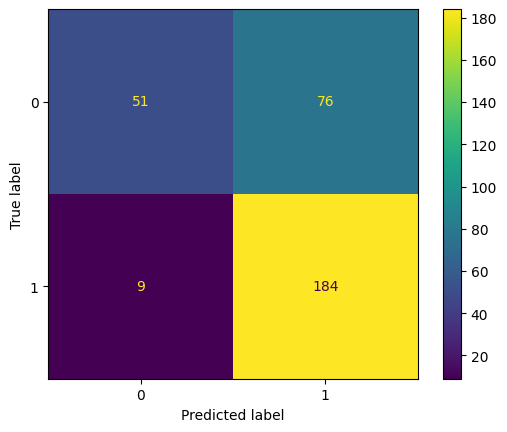

In [ ]:
ConfusionMatrixDisplay(cm).plot()